In [13]:
# NOTE: has to be done in python 2.7 as python 3 currently not supported by the fitparse package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitparse
%matplotlib inline

In [14]:
filename = 'run-20190309T074904.fit'
fitfile = fitparse.FitFile(filename)

In [15]:
record_df_list = [pd.concat([pd.DataFrame([record_data.value], columns=[record_data.name]) for record_data in record], axis=1) \
    for record in fitfile.get_messages('record')]
df = pd.concat(record_df_list, ignore_index=True)
print df.head(2)
print df.info()

   altitude  calories  distance  enhanced_altitude  enhanced_speed  \
0     168.6       0.0       0.0              168.6            0.00   
1     168.6       0.0       0.0              168.6            0.03   

   heart_rate  position_lat  position_long  speed           timestamp  
0        91.0   640072784.0    -21617298.0   0.00 2019-03-09 07:49:03  
1        91.0   640072808.0    -21617274.0   0.03 2019-03-09 07:49:04  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 10 columns):
altitude             2022 non-null float64
calories             2022 non-null float64
distance             2022 non-null float64
enhanced_altitude    2022 non-null float64
enhanced_speed       2022 non-null float64
heart_rate           2021 non-null float64
position_lat         2022 non-null float64
position_long        2022 non-null float64
speed                2022 non-null float64
timestamp            2023 non-null datetime64[ns]
dtypes: datetime64[ns](1), fl

In [16]:
df = df.dropna()
df = df.reset_index(drop=True)  # Drop the indices from the rows that were deleted (otherwise holds blank row)

In [17]:
tstamp_intervals = np.diff(df.timestamp)

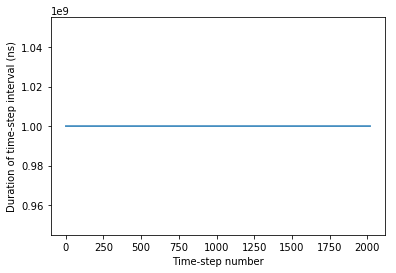

In [18]:
plt.plot(tstamp_intervals)
plt.ylabel('Duration of time-step interval (ns)')
plt.xlabel('Time-step number')
plt.show()

In [19]:
df.set_index('timestamp', inplace=True)  # Set the timestamp as the DataFrame index
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2021 entries, 2019-03-09 07:49:03 to 2019-03-09 08:22:43
Data columns (total 9 columns):
altitude             2021 non-null float64
calories             2021 non-null float64
distance             2021 non-null float64
enhanced_altitude    2021 non-null float64
enhanced_speed       2021 non-null float64
heart_rate           2021 non-null float64
position_lat         2021 non-null float64
position_long        2021 non-null float64
speed                2021 non-null float64
dtypes: float64(9)
memory usage: 157.9 KB


In [20]:
# Check if "enhanced speed/altitude" are the same as "speed/altitude"
print df.enhanced_altitude.equals(df.altitude)
print df.enhanced_speed.equals(df.speed)

True
True


In [21]:
# Remove enhanced columns as these are duplicates
df.drop(['enhanced_altitude', 'enhanced_speed'], axis=1, inplace=True)
print df.head()

                     altitude  calories  distance  heart_rate  position_lat  \
timestamp                                                                     
2019-03-09 07:49:03     168.6       0.0       0.0        91.0   640072784.0   
2019-03-09 07:49:04     168.6       0.0       0.0        91.0   640072808.0   
2019-03-09 07:49:05     168.6       0.0       0.0        91.0   640072844.0   
2019-03-09 07:49:06     168.6       0.0       0.0        92.0   640072892.0   
2019-03-09 07:49:07     168.6       0.0       0.0        94.0   640072927.0   

                     position_long  speed  
timestamp                                  
2019-03-09 07:49:03    -21617298.0   0.00  
2019-03-09 07:49:04    -21617274.0   0.03  
2019-03-09 07:49:05    -21617250.0   0.07  
2019-03-09 07:49:06    -21617227.0   0.16  
2019-03-09 07:49:07    -21617203.0   0.28  


Longitude and latitude are stored in some strange "semicircle" units, which is defined as
$$\frac{\text{long} \text{(lat)}}{\text{degrees}} = \text{semicircle} \times \frac{180}{2^{31}}$$
We may as well just replace these columns with values in degrees as these are more intuitive:

In [22]:
df['position_lat'] = df['position_lat'] * (180. / 2**31)
df['position_long'] = df['position_long'] * (180. / 2**31)
print df.loc[:, ['position_lat', 'position_long']].head(3)

                     position_lat  position_long
timestamp                                       
2019-03-09 07:49:03     53.650281      -1.811941
2019-03-09 07:49:04     53.650283      -1.811939
2019-03-09 07:49:05     53.650286      -1.811937


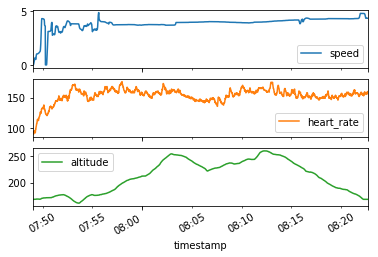

In [23]:
df[['speed', 'heart_rate', 'altitude']].plot(subplots=True)
plt.show()

In [24]:
# Save pickled dataframe to disk (heart rate + calories)
prefix = filename.split('.fit')[0]
df.to_pickle('./' + prefix + '-dataframe.pkl')